<a href="https://colab.research.google.com/github/davidogm/DataScience/blob/main/ITBD/trabajos2024/ITBD_P1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ITBD Práctica 1

 Eric Ayllon y Vicent Baeza

## Información del dataset

Nombre: [data_jobs](https://huggingface.co/datasets/lukebarousse/data_jobs)

Fuente: Huggingface

Tamaño:

    - Filas: 785,741
    - Columnas: 17

Tipo de contenido: información relativa a empleos en 2023

In [ ]:
import numpy as np
import pandas as pd

# para medir tiempo y sleep()
import time

# para el preprocesado
import ast
from sklearn.preprocessing import LabelEncoder

# librerías de gráficos
import matplotlib.pyplot as plt
from graphviz import Source

# para decision trees
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree

# predicción
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

## Análisis de tiempo de lectura de archivos

Vamos a analizar el tiempo que tardan se tardan los diferentes motores de lectura de la librería pandas en leer un fichero CSV. Analizaremos los siguientes modelos:

*   c
*   python
*   pyarrow

Analizaremos el tiempo que tardan estos 3 motores en cargar ficheros de distinto tamaño.

### Generación de Archivos

Como el motor 'pyarrow' no soporta la carga parcial de ficheros (no soporta el uso del parámetro *nrows*), tenemos que generar ficheros de varios tamaños a partir del dataset original.

In [ ]:
archivo_csv = "hf://datasets/lukebarousse/data_jobs/data_jobs.csv";
tamanyos = [   1000,   2000,   4000,   7000,
              10000,  20000,  40000,  70000,
             100000, 200000, 400000, 700000]

# Generar los archivos
dataframe = pd.read_csv(archivo_csv)
for tamanyo in tamanyos:
    dataframe.sample(n=tamanyo, random_state=123).to_csv(f'data_jobs{tamanyo}.csv', encoding='utf-8', index=False)
    print(f'Generado archivo: data_jobs{tamanyo}.csv')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generado archivo: data_jobs1000.csv
Generado archivo: data_jobs2000.csv
Generado archivo: data_jobs4000.csv
Generado archivo: data_jobs7000.csv
Generado archivo: data_jobs10000.csv
Generado archivo: data_jobs20000.csv
Generado archivo: data_jobs40000.csv
Generado archivo: data_jobs70000.csv
Generado archivo: data_jobs100000.csv
Generado archivo: data_jobs200000.csv
Generado archivo: data_jobs400000.csv
Generado archivo: data_jobs700000.csv


### Lectura de archivos

Una vez hemos generado los archivos de todos los tamaños, es hora de probar a cargar cada uno de los archivos con cada uno de los modelos y guardar todos los resultados. Tras obtener todos los resultados, los imprimimos por pantalla y los representamos en un gráfico.

Tiempos de carga (en s):
- 1000 filas: c=0.01s python=0.02s pyarrow=0.08s 
- 2000 filas: c=0.02s python=0.03s pyarrow=0.05s 
- 4000 filas: c=0.05s python=0.08s pyarrow=0.04s 
- 7000 filas: c=0.04s python=0.09s pyarrow=0.04s 
- 10000 filas: c=0.06s python=0.12s pyarrow=0.05s 
- 20000 filas: c=0.13s python=0.32s pyarrow=0.07s 
- 40000 filas: c=0.26s python=0.50s pyarrow=0.12s 
- 70000 filas: c=0.44s python=0.97s pyarrow=0.19s 
- 100000 filas: c=0.64s python=1.45s pyarrow=0.24s 
- 200000 filas: c=1.26s python=3.38s pyarrow=0.89s 
- 400000 filas: c=3.51s python=6.63s pyarrow=1.07s 
- 700000 filas: c=5.92s python=12.31s pyarrow=2.94s 


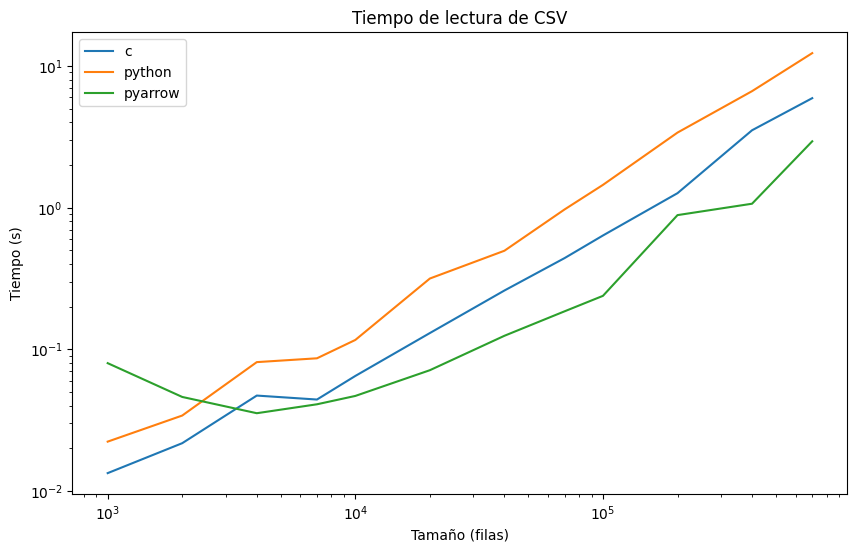

In [ ]:
motores = ['c', 'python', 'pyarrow']
resultados = {motor: [] for motor in motores}

# calcular tiempos de carga de archivos
print('Tiempos de carga (en s):')

# obtener tiempos e imprimirlos por pantalla
for tamanyo in tamanyos:
    print_str = (f"- {tamanyo} filas: ")
    for motor in motores:
        time.sleep(0.05) # para tiempos consistentes
        tiempo_inicio = time.time()
        dataframe = pd.read_csv(f'data_jobs{tamanyo}.csv', engine=motor)
        tiempo = time.time() - tiempo_inicio
        resultados[motor].append(tiempo)
        print_str += (f'{motor}={tiempo:.2f}s ')
    print(print_str)

# gráfico de lineas de los tiempos obtenidos
plt.figure(figsize=(10,6))
plt.title('Tiempo de lectura de CSV')
plt.xlabel('Tamaño (filas)')
plt.ylabel('Tiempo (s)')
plt.xscale('log')
plt.yscale('log')
for motor, tiempos in resultados.items():
    plt.plot(tamanyos, tiempos, label=motor)
plt.legend()
plt.show()

## Explicación y procesado de los dataframes

En este apartado se explicarán cada uno de los dataframes utilizados, junto con cualquier procesamiento que se haya hecho a los datos de los mismos.

### Jobs

El dataframe principal es **jobs**, que se ha obtenido de [esta dirección](https://huggingface.co/datasets/lukebarousse/data_jobs). Este dataframe tiene las siguientes columnas:
*   **job_title_short**: nombre resumido del puesto de trabajo ofertado
*   **job_title**: nombre completo del puesto de trabajo ofertado
*   **job_location**: ubicación del trabajo (ciudad o país)
*   **job_via**: la página de oferta de trabajo en la que se ha hecho la oferta de empleo
*   **job_schedule_type**: el tipo de horario de la oferta de trabajo (tiempo completo, tiempo parcial...)
*   **job_work_from_home**: si la oferta es teletrabajo
*   **search_location**: la ubicación aproximada de la oferta de trabajo
*   **job_posted_date**: la fecha de la oferta de trabajo
*   **job_no_degree_mentioned**: si la oferta requiere o menciona un grado universitario
*   **job_health_insurance**: si la oferta ofrece seguro médico
*   **job_country**: el país de la oferta
*   **salary_rate**: si el salario se ha especificado por hora o por anyo.
*   **salary_year_avg**: el salario por año de la oferta
*   **salary_hour_avg**: el salario por hora de la oferta
*   **company_name**: el nombre de la empresa
*   **job_skills**: las habilidades necesarias o recomendadas para la oferta
*   **job_type_skills**: las habilidades necesarias o recomendadas para la oferta, clasificadas por tipo de habilidad

In [ ]:
jobs = pd.read_csv("hf://datasets/lukebarousse/data_jobs/data_jobs.csv")
jobs.head()

,job_title_short,job_title,job_location,job_via,job_schedule_type,job_work_from_home,search_location,job_posted_date,job_no_degree_mention,job_health_insurance,job_country,salary_rate,salary_year_avg,salary_hour_avg,company_name,job_skills,job_type_skills
0,Senior Data Engineer,Senior Clinical Data Engineer / Principal Clin...,"Watertown, CT",via Work Nearby,Full-time,False,"Texas, United States",2023-06-16 13:44:15,False,False,United States,NaN,NaN,NaN,Boehringer Ingelheim,NaN,NaN
1,Data Analyst,Data Analyst,"Guadalajara, Jalisco, Mexico",via BeBee México,Full-time,False,Mexico,2023-01-14 13:18:07,False,False,Mexico,NaN,NaN,NaN,Hewlett Packard Enterprise,"['r', 'python', 'sql', 'nosql', 'power bi', 't...","{'analyst_tools': ['power bi', 'tableau'], 'pr..."
2,Data Engineer,"Data Engineer/Scientist/Analyst, Mid or Senior...","Berlin, Germany",via LinkedIn,Full-time,False,Germany,2023-10-10 13:14:55,False,False,Germany,NaN,NaN,NaN,ALPHA Augmented Services,"['python', 'sql', 'c#', 'azure', 'airflow', 'd...","{'analyst_tools': ['dax'], 'cloud': ['azure'],..."
3,Data Engineer,LEAD ENGINEER - PRINCIPAL ANALYST - PRINCIPAL ...,"San Antonio, TX",via Diversity.com,Full-time,False,"Texas, United States",2023-07-04 13:01:41,True,False,United States,NaN,NaN,NaN,Southwest Research Institute,"['python', 'c++', 'java', 'matlab', 'aws', 'te...","{'cloud': ['aws'], 'libraries': ['tensorflow',..."
4,Data Engineer,Data Engineer- Sr Jobs,"Washington, DC",via Clearance Jobs,Full-time,False,Sudan,2023-08-07 14:29:36,False,False,Sudan,NaN,NaN,NaN,Kristina Daniel,"['bash', 'python', 'oracle', 'aws', 'ansible',...","{'cloud': ['oracle', 'aws'], 'other': ['ansibl..."


#### Preprocesado de 'job_skills' y 'job_type_skills'
Como las columnas **job_skills** y **job_type_skills** son strings, vamos a procesarlas para obtener los datos que representan. Además, también calcularemos otras columnas que nos serán útiles para calcular futuras estadísticas. Almacenaremos las siguientes columnas adicionales:
- **skills**: almacena la columna **job_skills**, pero como set en vez de string
- **skill_count**: almacena la cantidad de habilidades de esta oferta
- **skills_dict**: almacena la columna **job_type_skills**, pero como diccionario en vez de string
- **skill_types**: almacena los tipos de habilidades necesarias para esta oferta, como array
- **skill_type_count**: almacena la cantidad de tipos de habilidades de esta oferta

In [ ]:
# valores que se consideran vacíos para la conversión de string a array/diccionario
listaValoresVacios = ['', 'nan', '[]', '()', '{}']

# convertir string a array
def parseArray(string):
  if str(string).strip().lower() in listaValoresVacios:
    return {};
  array = ast.literal_eval(str(string))
  return {s for s in array} # convertir a set() por eficiencia

# convertir string a diccionario
def parseDict(string):
  if str(string).strip().lower() in listaValoresVacios:
    return {};
  return ast.literal_eval(str(string))

# generar nuevas columnas
jobs['skills'] = jobs['job_skills'].apply(parseArray)
jobs['skill_count'] = jobs['skills'].apply(lambda x: len(x))
jobs['skills_dict'] = jobs['job_type_skills'].apply(parseDict)
jobs['skill_types'] = jobs['skills_dict'].apply(lambda x: x.keys())
jobs['skill_type_count'] = jobs['skill_types'].apply(lambda x: len(x))

jobs.head()

,job_title_short,job_title,job_location,job_via,job_schedule_type,job_work_from_home,search_location,job_posted_date,job_no_degree_mention,job_health_insurance,...,salary_year_avg,salary_hour_avg,company_name,job_skills,job_type_skills,skills,skill_count,skills_dict,skill_types,skill_type_count
0,Senior Data Engineer,Senior Clinical Data Engineer / Principal Clin...,"Watertown, CT",via Work Nearby,Full-time,False,"Texas, United States",2023-06-16 13:44:15,False,False,...,NaN,NaN,Boehringer Ingelheim,NaN,NaN,{},0,{},(),0
1,Data Analyst,Data Analyst,"Guadalajara, Jalisco, Mexico",via BeBee México,Full-time,False,Mexico,2023-01-14 13:18:07,False,False,...,NaN,NaN,Hewlett Packard Enterprise,"['r', 'python', 'sql', 'nosql', 'power bi', 't...","{'analyst_tools': ['power bi', 'tableau'], 'pr...","{python, tableau, r, nosql, power bi, sql}",6,"{'analyst_tools': ['power bi', 'tableau'], 'pr...","(analyst_tools, programming)",2
2,Data Engineer,"Data Engineer/Scientist/Analyst, Mid or Senior...","Berlin, Germany",via LinkedIn,Full-time,False,Germany,2023-10-10 13:14:55,False,False,...,NaN,NaN,ALPHA Augmented Services,"['python', 'sql', 'c#', 'azure', 'airflow', 'd...","{'analyst_tools': ['dax'], 'cloud': ['azure'],...","{dax, azure, python, c#, docker, jenkins, airf...",9,"{'analyst_tools': ['dax'], 'cloud': ['azure'],...","(analyst_tools, cloud, libraries, other, progr...",5
3,Data Engineer,LEAD ENGINEER - PRINCIPAL ANALYST - PRINCIPAL ...,"San Antonio, TX",via Diversity.com,Full-time,False,"Texas, United States",2023-07-04 13:01:41,True,False,...,NaN,NaN,Southwest Research Institute,"['python', 'c++', 'java', 'matlab', 'aws', 'te...","{'cloud': ['aws'], 'libraries': ['tensorflow',...","{keras, pytorch, aws, python, c++, matlab, jav...",8,"{'cloud': ['aws'], 'libraries': ['tensorflow',...","(cloud, libraries, programming)",3
4,Data Engineer,Data Engineer- Sr Jobs,"Washington, DC",via Clearance Jobs,Full-time,False,Sudan,2023-08-07 14:29:36,False,False,...,NaN,NaN,Kristina Daniel,"['bash', 'python', 'oracle', 'aws', 'ansible',...","{'cloud': ['oracle', 'aws'], 'other': ['ansibl...","{bash, ansible, aws, oracle, python, gitlab, j...",9,"{'cloud': ['oracle', 'aws'], 'other': ['ansibl...","(cloud, other, programming)",3


#### Preprocesado de 'job_via'

La columna **job_via** indica el método por el que se ha publicado la oferta, que generalmente es el nombre de la página web de ofertas de empleo en la que está.

El problema es que muchas de las páginas de empleo tienen sub-páginas, por lo que tenemos cientos de valores diferentes en esta columna. Por ejemplo, BeeBee tiene una página diferente para cada país (BeeBee México, BeeBee Portugal, etc.).

Para solucionar esto, agruparemos los valores, de forma de que si un valor es un substring de otro, los dos pasarán a ser el mismo valor. Esto solo se hará para valores con bastantes ofertas (>1000), ya que solo queremos agrupar las páginas grandes con sus sub-páginas. También quitaremos las palabras 'via ' presentes en todos los valores, y pasaremos todo a minúsculas, con el fin de mejorar la agrupación de valores.

Para conservar los datos originales, guardaremos el resultado de todo esto en una nueva columna, llamada **via**.

In [ ]:
# quitar prefijo 'via ' y convertir a minúsculas
def procesarVia(string):
  return str(string).removeprefix('via ').lower()

# probar a agrupar con 'grupo'
agrupaciones = []
def agrupar(string, grupo):
  global agrupaciones
  if len(string) <= len(grupo): # por eficiencia
    return string

  if grupo in string.replace(' ', '').replace('-', ''):
    agrupaciones.append(string)
    return grupo
  return string

# obtener "vias" con más de 500 ofertas
jobs['via'] = jobs['job_via'].apply(procesarVia)
vias = jobs['via'].value_counts().reset_index(name='counts')
vias = vias[vias['counts'] > 500]

# agrupar con todas las "vias" con más de 500 ofertas
print('Agrupaciones:')
for index, row in vias.iterrows():
  agrupaciones.clear()
  grupo = str(row['via']).replace(' ', '')
  jobs['via'] = jobs['via'].apply(lambda x: agrupar(x, grupo))
  if agrupaciones:
    print(f'- {grupo}: {list(dict.fromkeys(agrupaciones))}')

# obtener resultado final
vias = jobs['via'].value_counts().reset_index(name='counts')


Agrupaciones:
- linkedin: ['linkedin uruguay', 'linkedin estonia', 'linkedin hungary', 'linkedin belgium', 'linkedin nigeria', 'linkedin الأردن', 'linkedin armenia', 'linkedin philippines', 'linkedin maurice', 'linkedin reunion', 'linkedin bulgaria', 'linkedin تونس', 'linkedin costa rica', 'linkedin moldova', 'linkedin vietnam', 'linkedin hong kong', 'linkedin senegal', 'hu.linkedin.com', 'linkedin latvia', 'linkedin iceland', 'linkedin slovakia', 'linkedin luxembourg', 'linkedin myanmar', 'linkedin kazakhstan', 'linkedin malta', 'linkedin finland', 'linkedin العراق', 'ua.linkedin.com', 'linkedin الإمارات', 'linkedin albania', 'linkedin perú', 'linkedin guatemala', 'linkedin uganda', 'linkedin república dominicana', 'linkedin honduras', 'linkedin puerto rico', 'linkedin lithuania', 'linkedin سلطنة عمان', 'linkedin قطر', 'linkedin cyprus', 'linkedin pakistan', 'linkedin panamá', 'linkedin uzbekistan', 'linkedin ethiopia', 'linkedin liberia', 'linkedin montenegro', 'linkedin mongolia', '

#### Preprocesado de 'job_title_short'

En nuestro dataset, la columna **job_title_short** tiene los siguientes posibles valores:
- Data Analyst
- Data Engineer
- Data Scientist
- Business Analyst
- Software Engineer
- Senior Data Engineer
- Senior Data Scientist
- Senior Data Analyst
- Machine Learning Engineer
- Cloud Engineer

Para poder calcular ciertas estadísticas en un futuro, dividiremos la información de esta columna en dos: si el trabajo es senior o no, y el nombre del trabajo (exceptuando la palabra 'Senior '). Almacenaremos el resultado en las siguientes columnas:
- **title**: el nombre del trabajo
- **senior**: si el puesto es de senior o no


In [ ]:
# quitar prefijo 'Senior '
def procesarTitle(string):
  return str(string).removeprefix('Senior ')

# ver si tiene el prefijo 'Senior'
def procesarSenior(string):
  return str(string).startswith('Senior')

# generar columnas
jobs['title'] = jobs['job_title_short'].apply(procesarTitle)
jobs['senior'] = jobs['job_title_short'].apply(procesarSenior)

jobs.head()

,job_title_short,job_title,job_location,job_via,job_schedule_type,job_work_from_home,search_location,job_posted_date,job_no_degree_mention,job_health_insurance,...,job_type_skills,skills,skill_count,skills_dict,skill_types,skill_type_count,via,title,keyword,senior
0,Senior Data Engineer,Senior Clinical Data Engineer / Principal Clin...,"Watertown, CT",via Work Nearby,Full-time,False,"Texas, United States",2023-06-16 13:44:15,False,False,...,NaN,{},0,{},(),0,work nearby,Data Engineer,Engineer,True
1,Data Analyst,Data Analyst,"Guadalajara, Jalisco, Mexico",via BeBee México,Full-time,False,Mexico,2023-01-14 13:18:07,False,False,...,"{'analyst_tools': ['power bi', 'tableau'], 'pr...","{python, tableau, r, nosql, power bi, sql}",6,"{'analyst_tools': ['power bi', 'tableau'], 'pr...","(analyst_tools, programming)",2,bebee,Data Analyst,Analyst,False
2,Data Engineer,"Data Engineer/Scientist/Analyst, Mid or Senior...","Berlin, Germany",via LinkedIn,Full-time,False,Germany,2023-10-10 13:14:55,False,False,...,"{'analyst_tools': ['dax'], 'cloud': ['azure'],...","{dax, azure, python, c#, docker, jenkins, airf...",9,"{'analyst_tools': ['dax'], 'cloud': ['azure'],...","(analyst_tools, cloud, libraries, other, progr...",5,linkedin,Data Engineer,Engineer,False
3,Data Engineer,LEAD ENGINEER - PRINCIPAL ANALYST - PRINCIPAL ...,"San Antonio, TX",via Diversity.com,Full-time,False,"Texas, United States",2023-07-04 13:01:41,True,False,...,"{'cloud': ['aws'], 'libraries': ['tensorflow',...","{keras, pytorch, aws, python, c++, matlab, jav...",8,"{'cloud': ['aws'], 'libraries': ['tensorflow',...","(cloud, libraries, programming)",3,diversity.com,Data Engineer,Engineer,False
4,Data Engineer,Data Engineer- Sr Jobs,"Washington, DC",via Clearance Jobs,Full-time,False,Sudan,2023-08-07 14:29:36,False,False,...,"{'cloud': ['oracle', 'aws'], 'other': ['ansibl...","{bash, ansible, aws, oracle, python, gitlab, j...",9,"{'cloud': ['oracle', 'aws'], 'other': ['ansibl...","(cloud, other, programming)",3,clearancejobs,Data Engineer,Engineer,False


#### Otros preprocesados

Para ciertas estadísticas, nos será necesario obtener la fecha de la oferta. Para esto, redondearemos la fecha y hora de la oferta, de forma de que todas las ofertas del mismo día sean el mismo valor. También generaremos la columna **id**, que nos servirá para relacionar fácilmente este dataset con los datasets derivados. Generaremos las siguientes columnas:
- **date**: la fecha en la que se publicó la oferta, pero como *datetime* y redondeado al día
- **month**: el mes en el que se publicó la oferta
- **id**: id que representa esta oferta de trabajo. Nos servirá para generar conectar otros dataframes con este.

In [ ]:
jobs['date'] = pd.to_datetime(jobs['job_posted_date']).dt.floor('d')
jobs['month'] = jobs['date'].dt.month
jobs['id'] = jobs.index

jobs.head()

,job_title_short,job_title,job_location,job_via,job_schedule_type,job_work_from_home,search_location,job_posted_date,job_no_degree_mention,job_health_insurance,...,skills_dict,skill_types,skill_type_count,via,title,keyword,senior,date,month,id
0,Senior Data Engineer,Senior Clinical Data Engineer / Principal Clin...,"Watertown, CT",via Work Nearby,Full-time,False,"Texas, United States",2023-06-16 13:44:15,False,False,...,{},(),0,work nearby,Data Engineer,Engineer,True,2023-06-16,6,0
1,Data Analyst,Data Analyst,"Guadalajara, Jalisco, Mexico",via BeBee México,Full-time,False,Mexico,2023-01-14 13:18:07,False,False,...,"{'analyst_tools': ['power bi', 'tableau'], 'pr...","(analyst_tools, programming)",2,bebee,Data Analyst,Analyst,False,2023-01-14,1,1
2,Data Engineer,"Data Engineer/Scientist/Analyst, Mid or Senior...","Berlin, Germany",via LinkedIn,Full-time,False,Germany,2023-10-10 13:14:55,False,False,...,"{'analyst_tools': ['dax'], 'cloud': ['azure'],...","(analyst_tools, cloud, libraries, other, progr...",5,linkedin,Data Engineer,Engineer,False,2023-10-10,10,2
3,Data Engineer,LEAD ENGINEER - PRINCIPAL ANALYST - PRINCIPAL ...,"San Antonio, TX",via Diversity.com,Full-time,False,"Texas, United States",2023-07-04 13:01:41,True,False,...,"{'cloud': ['aws'], 'libraries': ['tensorflow',...","(cloud, libraries, programming)",3,diversity.com,Data Engineer,Engineer,False,2023-07-04,7,3
4,Data Engineer,Data Engineer- Sr Jobs,"Washington, DC",via Clearance Jobs,Full-time,False,Sudan,2023-08-07 14:29:36,False,False,...,"{'cloud': ['oracle', 'aws'], 'other': ['ansibl...","(cloud, other, programming)",3,clearancejobs,Data Engineer,Engineer,False,2023-08-07,8,4


### Skills

A partir del dataframe **jobs**, podemos expandir la columna de **skills**, haciendo que cada elemento del array de la columna sea su propia fila. A partir de esto obtenemos el dataframe **Skills**, que nos relaciona cada habilidad con las ofertas de trabajo que la mencionan. **Skills** contiene las siguientes columnas:
- **skill**: nombre de la habilidad. Para las ofertas que no mencionen ninguna habilidad, se introducirá el string 'N/A'
- **id**: id de la oferta de trabajo en el dataframe **jobs**


In [ ]:
skills = jobs.explode('skills')[['skills', 'id']].rename(columns={'skills': 'skill'}).fillna('N/A')

skills

,skill,id
0,N/A,0
1,python,1
1,tableau,1
1,r,1
1,nosql,1
...,...,...
785739,nosql,785739
785739,snowflake,785739
785739,sql,785739
785740,aws,785740


### Skill Types

De forma muy similar que con el dataframe **skills**, podemos obtener un dataframe pero que relacione los tipos de habilidades con las ofertas de trabajo que los mencionan. El dataframe **Skill Types** las siguientes columnas:
- **skill_type**: el tipo de habilidad. Para las ofertas que no mencionen ningun tipo de habilidad, se introducirá el string 'N/A'
- **id**: id de la oferta de trabajo en el dataframe **jobs**

In [ ]:
skill_types = jobs.explode('skill_types')[['skill_types', 'id']].rename(columns={'skill_types': 'skill_type'}).fillna('N/A')

skill_types

,skill_type,id
0,N/A,0
1,analyst_tools,1
1,programming,1
2,analyst_tools,2
2,cloud,2
...,...,...
785739,libraries,785739
785739,other,785739
785739,programming,785739
785740,cloud,785740


### Predicción

Para el apartado de predicción, vamos a intentar predecir el título del trabajo (la columna **title**) a partir de las habilidades que menciona (la columna **skills**). Para esto, necesitaremos convertir la columna **skills** a algo más fácil de procesar que un array de strings.

Para esto, generaremos datasets en los que cada skill han sido convertida en una columna, en la que un 1 significa que esa habilidad es mencionada en esa oferta y un 0 que no. Utilizaremos las *skills* que se mencionen en almenos 10000 ofertas.

In [ ]:
def porcentajeTipo(skills_dict, tipo, total):
  if total == 0:
    return 0
  return len(skills_dict.get(tipo, [])) / total

# obtener tipos habilidades
tipos_habilidades = skill_types['skill_type'][skill_types['skill_type'] != 'N/A'].value_counts().reset_index(name='counts')
tipos_habilidades_id = skill_types[skill_types['skill_type'].isin(tipos_habilidades['skill_type'])]
labels_prediccion = list(tipos_habilidades['skill_type'])

# obtener habilidades con >10000 menciones
top_habilidades = skills['skill'][skills['skill'] != 'N/A'].value_counts().reset_index(name='counts')
top_habilidades = top_habilidades[top_habilidades['counts'] > 10000]
top_habilidades_id = skills[skills['skill'].isin(top_habilidades['skill'])]
labels_prediccion += list(top_habilidades['skill'])

# filtrar trabajos sin habilidades
jobs_filtered = jobs[jobs['skill_count'] > 0]

# filtrar trabajos duplicados
jobs_filtered = jobs.drop_duplicates(subset=['job_skills'], keep=False)
jobs_filtered = jobs.drop_duplicates(subset=['job_type_skills'], keep=False)

# generar la Y (a partir de los códigos de jobs['title']):
leY = LabelEncoder()
y = leY.fit_transform(jobs_filtered['title']) # la Y es el título del trabajo (como código)

# generar X (porcentajes)
X = jobs_filtered[['id', 'skills_dict', 'skill_count']].copy()
for index, row in tipos_habilidades.iterrows():
  print(f'Generando porcentaje: {row["skill_type"]}')
  X[row['skill_type']] = X.apply(lambda x: porcentajeTipo(x['skills_dict'], row['skill_type'], x['skill_count']), axis=1)

# generar X (clasificaciones binarias)
print('Generando clasificaciones binarias')
for index, row in top_habilidades.iterrows():
  X[row['skill']] = X['id'].isin(top_habilidades_id[top_habilidades_id['skill'] == row['skill']]['id']).astype(int)

X = X.drop(columns=['id', 'skills_dict', 'skill_count'])
X

# imprimir X e Y a la vez
XY = X.copy()
XY['Y'] = y
XY['Y (str)'] = leY.inverse_transform(XY['Y'])
XY

Generando porcentaje: programming
Generando porcentaje: analyst_tools
Generando porcentaje: cloud
Generando porcentaje: libraries
Generando porcentaje: other
Generando porcentaje: databases
Generando porcentaje: os
Generando porcentaje: webframeworks
Generando porcentaje: async
Generando porcentaje: sync
Generando clasificaciones binarias


,programming,analyst_tools,cloud,libraries,other,databases,os,webframeworks,async,sync,...,vba,cassandra,keras,alteryx,matlab,unix,confluence,spss,Y,Y (str)
2,0.333333,0.111111,0.111111,0.111111,0.333333,0.000,0.000000,0.000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,3,Data Engineer
7,0.181818,0.000000,0.545455,0.272727,0.000000,0.000,0.000000,0.000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,3,Data Engineer
12,0.333333,0.500000,0.000000,0.000000,0.000000,0.000,0.000000,0.000,0.166667,0.000000,...,0,0,0,0,0,0,0,0,2,Data Analyst
57,0.125000,0.250000,0.250000,0.000000,0.000000,0.375,0.000000,0.000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,3,Data Engineer
75,0.666667,0.000000,0.000000,0.000000,0.111111,0.000,0.111111,0.000,0.111111,0.000000,...,0,0,0,0,1,0,0,0,4,Data Scientist
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785697,0.300000,0.500000,0.000000,0.000000,0.000000,0.000,0.000000,0.000,0.200000,0.000000,...,0,0,0,0,0,0,1,0,4,Data Scientist
785721,0.181818,0.272727,0.090909,0.000000,0.090909,0.000,0.000000,0.000,0.272727,0.090909,...,0,0,0,0,0,0,1,0,0,Business Analyst
785725,0.166667,0.000000,0.166667,0.166667,0.500000,0.000,0.000000,0.000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,4,Data Scientist
785735,0.250000,0.000000,0.250000,0.125000,0.250000,0.000,0.000000,0.125,0.000000,0.000000,...,0,0,0,0,0,0,0,0,3,Data Engineer


## Análisis de los datos

### Tipos de habilidades mencionadas en ofertas de trabajo

La cantidad total de veces que se ha mencionado cada tipo de habilidad, siendo 'N/A' la cantidad de ofertas de empleo que no mencionan ningún tipo de habilidad.

Text(0, 0.5, 'Número de ofertas en las que se menciona')

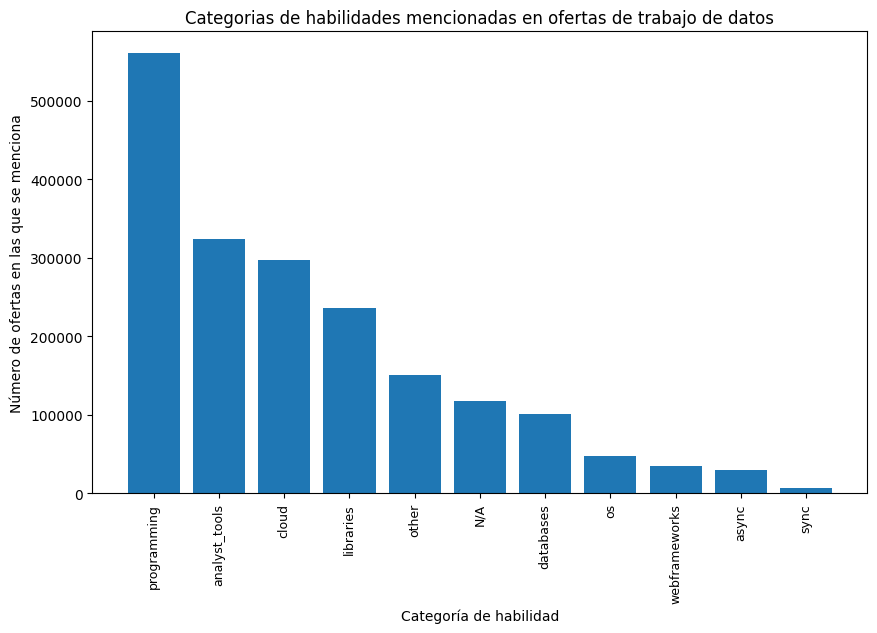

In [ ]:
frecuencia_tipos = skill_types['skill_type'].value_counts().reset_index(name='counts')

plt.figure(figsize=(10,6))
plt.title("Tipos de habilidades mencionadas en ofertas de trabajo de datos")
plt.bar(frecuencia_tipos['skill_type'], frecuencia_tipos['counts'])
# plt.xticks(fontsize=10)
plt.xticks(fontsize=9, rotation=90)
plt.xlabel("Tipo de habilidad")
plt.ylabel("Número de ofertas en las que se menciona")

Como se puede comprobar, en el rango temporal que abarca este conjunto de datos, hay una cantidad puestos de trabajo nuevos que requieren conocimiento de programación bastante grande. Esto puede deberse a la creciente digitalización de muchos procesos relativos tanto a la gestión y funcionamiento de empresas como a los órganos de gobierno. Por otro lado, también se puede ver que se le da bastante importancia al uso de herramientas de análisis de datos y tecnologías cloud. Esto puede deberse al creciente uso de la Inteligencia Artificial, ya que la inteligencia artificial moderna requiere el uso de cantidades elevadas de datos, algunos de cierta complejidad que necesita un análisis previo a su uso.

### Número de ofertas por día que mencionan cada tipo de habilidad

La cantidad total de ofertas que mencionan cada tipo de habilidad, para cada día

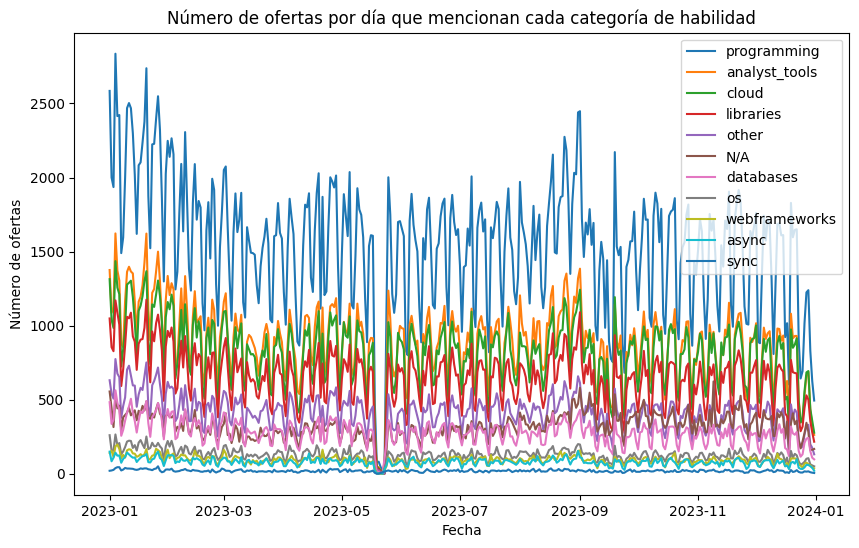

In [ ]:
# obtener habilidades
habilidades_values = skill_types['skill_type'].value_counts().reset_index(name='counts')
habilidades = skill_types[skill_types['skill_type'].isin(habilidades_values['skill_type'])]

# combinar con 'jobs' y agrupar por fecha
habilidades_jobs = jobs.join(habilidades.set_index('id'), on='id')
habilidades_fechas = habilidades_jobs.groupby(['skill_type', 'date']).size().reset_index(name='counts')

# dibujar gráfico
plt.figure(figsize=(10,6))
plt.title('Número de ofertas por día que mencionan cada tipo de habilidad')
plt.xlabel('Fecha')
plt.ylabel('Número de ofertas')
for index, row in habilidades_values.iterrows():
  datos_habilidad = habilidades_fechas[habilidades_fechas['skill_type'] == row['skill_type']]
  plt.plot(datos_habilidad['date'], datos_habilidad['counts'], label=row['skill_type'])
plt.legend()
plt.show()

En la gráfica generada se puede comprobar un par de detalles. Para empezar, alrededor del mes de junio hay un vacío de ofertas, lo cuál puede deberse a un error en el proceso de recolección de los datos. Otro detalle que se puede visualizar en esta gráfica es que los cuatro tipos más solicitados tienen tendencias bastante similares, lo cuál podría indicar que hay una gran cantidad de ofertas que requieren estos cuatro tipos. Sorprendentemente, también hay una cantidad bastante notable de ofertas de trabajo que no indican ningún requisito referente a las habilidades.

### Ratio de ofertas en común de los tipos de habilidades

Dado cada tipo de habilidad, obtenemos la proporcion de ofertas que tienen en común con los otros tipos de habilidades. Esto lo representaremos como un mapa de calor de todos los tipos de habilidades.


Ratio de ofertas en común: 
- programming: 'programming'=1.00 'cloud'=0.48 'analyst_tools'=0.45 'libraries'=0.40 'other'=0.24 'databases'=0.18 'os'=0.07 'webframeworks'=0.06 'async'=0.04 'sync'=0.01
- analyst_tools: 'analyst_tools'=1.00 'programming'=0.78 'cloud'=0.36 'libraries'=0.23 'other'=0.15 'databases'=0.14 'async'=0.04 'os'=0.04 'webframeworks'=0.04 'sync'=0.01
- cloud: 'cloud'=1.00 'programming'=0.90 'libraries'=0.50 'analyst_tools'=0.40 'other'=0.33 'databases'=0.24 'os'=0.09 'webframeworks'=0.06 'async'=0.05 'sync'=0.01
- libraries: 'libraries'=1.00 'programming'=0.94 'cloud'=0.63 'other'=0.37 'analyst_tools'=0.32 'databases'=0.23 'os'=0.09 'webframeworks'=0.08 'async'=0.05 'sync'=0.01
- other: 'other'=1.00 'programming'=0.90 'cloud'=0.65 'libraries'=0.58 'analyst_tools'=0.32 'databases'=0.24 'os'=0.14 'async'=0.10 'webframeworks'=0.10 'sync'=0.02
- databases: 'databases'=1.00 'programming'=0.97 'cloud'=0.71 'libraries'=0.53 'analyst_tools'=0.45 'other'=0.36 'os'=0.13 'webfr

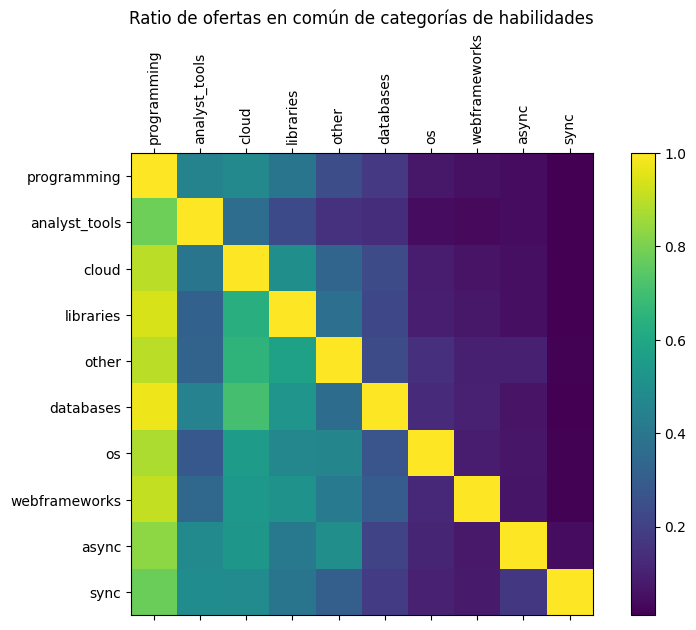

In [ ]:
# obtener top 10 habilidades (excepto 'N/A')
top_habilidades = skill_types[skill_types['skill_type'] != 'N/A']['skill_type'].value_counts().reset_index(name='counts').head(10)
top_habilidades['index'] = top_habilidades.index
top_habilidades_id = skill_types[skill_types['skill_type'].isin(top_habilidades['skill_type'])]
num_habilidades = len(top_habilidades)

# obtener diccionario de correlacion
correlaciones = []
print('Ratio de ofertas en común: ')
for index, row in top_habilidades.iterrows():
  # obtener trabajos de la habilidad
  ids = skill_types[skill_types['skill_type'] == row['skill_type']]['id']
  total_trabajos = len(ids)

  # obtener numero de trabajos con las otras habilidades
  habilidades = skill_types[skill_types['id'].isin(ids)]
  habilidades = habilidades[habilidades['skill_type'].isin(top_habilidades['skill_type'])]
  habilidades_counts = habilidades['skill_type'].value_counts().reset_index(name='counts')

  # obtener resultados y guardarlos en una matriz:
  print_str = f'- {row["skill_type"]}:'
  correlaciones_skill = [0] * num_habilidades
  for index2, row2 in habilidades_counts.iterrows():
    correlacion = row2['counts'] / total_trabajos
    nombre_skill = row2['skill_type']
    indice_skill = top_habilidades[top_habilidades['skill_type'] == nombre_skill].iloc[0]['index']
    correlaciones_skill[indice_skill] = correlacion
    print_str += f' \'{nombre_skill}\'={correlacion:.2f}'
  print(print_str)
  correlaciones.append(correlaciones_skill)

# dibujar matriz resultante
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
cax = ax.matshow(correlaciones)
plt.title('Ratio de ofertas en común de los tipos de habilidades')
fig.colorbar(cax)
plt.xticks(top_habilidades['index'], top_habilidades['skill_type'])
plt.yticks(top_habilidades['index'], top_habilidades['skill_type'])
plt.xticks(rotation=90)
plt.show()


En el mapa de calor obtenido, como es de esperar, la diagonal vale 1. También se puede ver que el tipo 'programming' correla bastante con el resto de tipos, pero el resto de tipos no suelen correlar demasiado con los otros.


A continuación se proporcionarán unos análisis similares, esta vez con un nivel mayor de granularidad. Se estudiarán las mismas estadísticas pero para las N habilidades más solicitadas.

### Frecuencia de mención de habilidades en ofertas de trabajo de datos

La cantidad total de veces que se ha mencionado cada habilidad, siendo 'N/A' la cantidad de ofertas de empleo que no mencionan ninguna habilidad.

Text(0, 0.5, 'Número de ofertas')

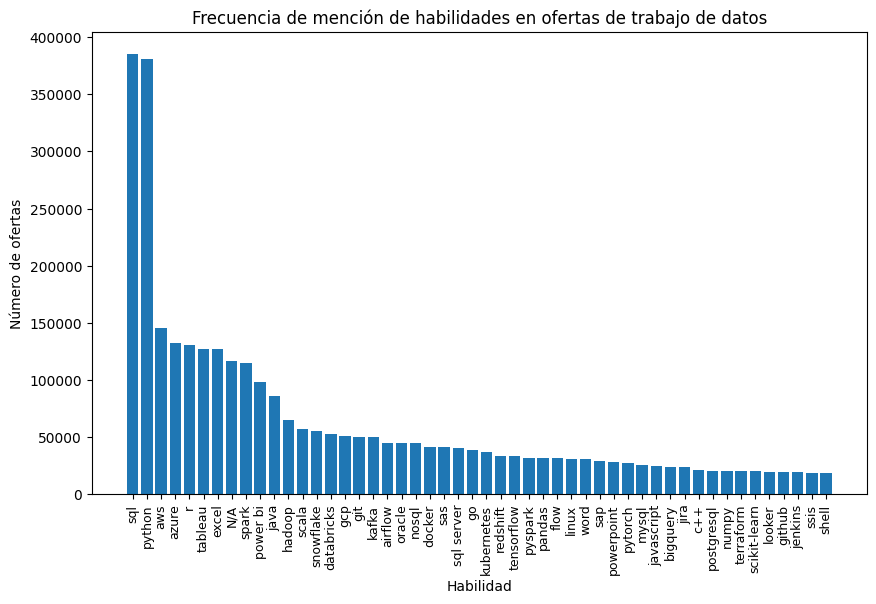

In [ ]:
frecuencia_habilidades = skills['skill'].value_counts().reset_index(name='counts')

plt.figure(figsize=(10,6))
plt.title("Frecuencia de mención de habilidades en ofertas de trabajo de datos")
plt.bar(frecuencia_habilidades['skill'].head(50),frecuencia_habilidades['counts'].head(50))
plt.xticks(fontsize=9, rotation=90)
plt.xlabel("Habilidad")
plt.ylabel("Número de ofertas")

Las habilidades más solicitadas en las ofertas de trabajo son sql y python. Esto puede deberse a la masificación de dos tendencias: aplicaciones que manejan bases de datos y puestos de trabajo que requieren de programación a alto nivel. Un detalle que oculta esta gráfica es el número de trabajos que no surgen como ofertas de empleo, sino como empleos que ya existían. Esto quiere decir que pueden haber habilidades que son bastante importantes y bastante solicitadas pero que no se incluyen en las ofertas de trabajo ya que los puestos que requieren estas habilidades ya están cubiertos. Por este motivo, solo se puede hablar de tendencias y no de valores absolutos. En el rango de fechas cubierto se generan muchos empleos nuevos que requieren conocimiento sobre python y sql, pero no se puede deducir qué porcentaje de puestos de trabajo suponen estas ofertas.

### Número de ofertas por día de las 5 habilidades más frecuentes





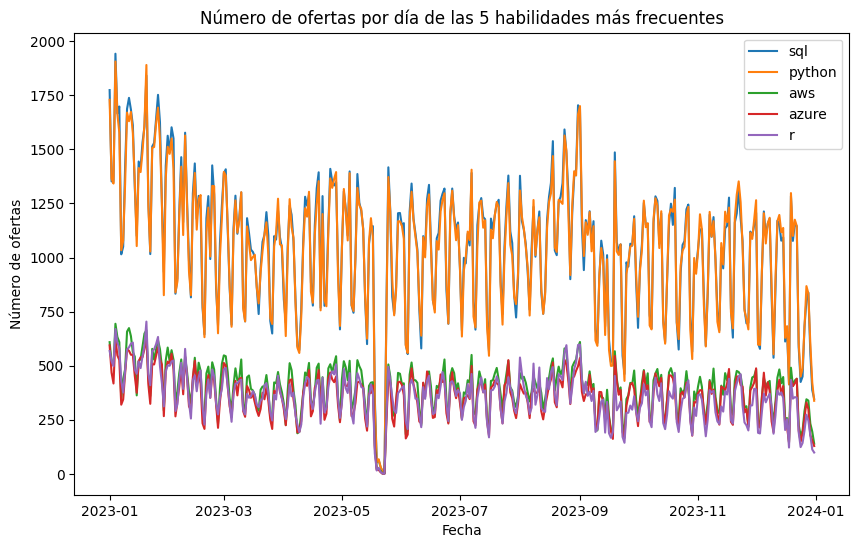

In [ ]:
# obtener top 5 habilidades
top_habilidades_skill = skills['skill'].value_counts().reset_index(name='counts').head(5)
top_habilidades = skills[skills['skill'].isin(top_habilidades_skill['skill'])]

# combinar con 'jobs' y agrupar por fecha
top_habilidades_jobs = jobs.join(top_habilidades.set_index('id'), on='id')
top_habilidades_fechas = top_habilidades_jobs.groupby(['skill', 'date']).size().reset_index(name='counts')

# dibujar gráfico
plt.figure(figsize=(10,6))
plt.title('Número de ofertas por día de las 5 habilidades más frecuentes')
plt.xlabel('Fecha')
plt.ylabel('Número de ofertas')
for index, row in top_habilidades_skill.iterrows():
  datos_habilidad = top_habilidades_fechas[top_habilidades_fechas['skill'] == row['skill']]
  plt.plot(datos_habilidad['date'], datos_habilidad['counts'], label=row['skill'])
plt.legend()
plt.show()

Al igual que con los tipos, se puede intuir que hay alguna correlación entre las habilidades más solicitadas. En el caso de los tipos de habilidades sí se podía observar una correlación, lo cuál puede significar que los empleos generados durante este periodo pueden estar pensados para tareas que requieran ambas habilidades. Algunos trabajos relacionados inteligencia artificial suelen implicar trabajo con grandes bases de datos y uso intensivo del lenguaje de programación python. Por otra parte, al igual que con los tipos de habilidades, alrededor del mes de junio hay un curioso vacío, de nuevo, este podría deberse a un error en el proceso de recolección de datos.

### Ratio de ofertas en común de las 10 habilidades más frecuentes

Dada cada una de las 10 habilidades más frecuentes, obtenemos la proporcion de ofertas que tienen en común con cada una de las otras 10 habilidades más frecuentes. Al igual que con los tipos de habilidades, lo expresaremos como un mapa de calor.


Ratio de ofertas en común: 
- sql: 'sql'=1.00 'python'=0.66 'tableau'=0.25 'r'=0.24 'aws'=0.24 'azure'=0.23 'spark'=0.20 'power bi'=0.18 'excel'=0.17 'java'=0.14
- python: 'python'=1.00 'sql'=0.66 'r'=0.31 'aws'=0.29 'spark'=0.25 'azure'=0.23 'tableau'=0.21 'java'=0.18 'power bi'=0.13 'excel'=0.11
- aws: 'aws'=1.00 'python'=0.76 'sql'=0.63 'azure'=0.41 'spark'=0.34 'java'=0.23 'tableau'=0.17 'r'=0.16 'power bi'=0.09 'excel'=0.06
- azure: 'azure'=1.00 'sql'=0.68 'python'=0.67 'aws'=0.45 'spark'=0.31 'power bi'=0.21 'java'=0.19 'r'=0.16 'tableau'=0.15 'excel'=0.06
- r: 'r'=1.00 'python'=0.92 'sql'=0.70 'tableau'=0.33 'power bi'=0.19 'spark'=0.19 'excel'=0.18 'aws'=0.18 'azure'=0.17 'java'=0.14
- tableau: 'tableau'=1.00 'sql'=0.76 'python'=0.63 'power bi'=0.35 'r'=0.34 'excel'=0.28 'aws'=0.19 'azure'=0.15 'spark'=0.14 'java'=0.10
- excel: 'excel'=1.00 'sql'=0.53 'python'=0.34 'tableau'=0.28 'power bi'=0.24 'r'=0.19 'azure'=0.07 'aws'=0.06 'spark'=0.05 'java'=0.04
- spark: 'spark'=1.00 'py

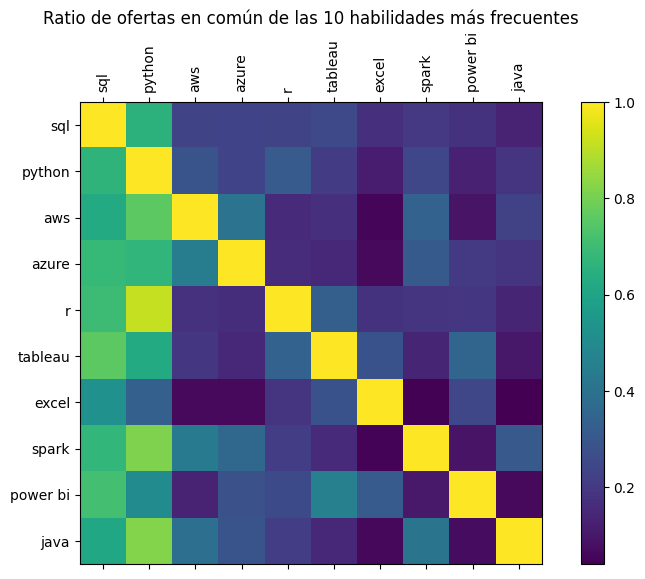

In [ ]:
# obtener top 10 habilidades (excepto 'N/A')
top_habilidades = skills[skills['skill'] != 'N/A']['skill'].value_counts().reset_index(name='counts').head(10)
top_habilidades['index'] = top_habilidades.index
top_habilidades_id = skills[skills['skill'].isin(top_habilidades['skill'])]
num_habilidades = len(top_habilidades)

# obtener diccionario de correlacion
correlaciones = []
print('Ratio de ofertas en común: ')
for index, row in top_habilidades.iterrows():
  # obtener trabajos de la habilidad
  ids = skills[skills['skill'] == row['skill']]['id']
  total_trabajos = len(ids)

  # obtener numero de trabajos con las otras habilidades
  habilidades = skills[skills['id'].isin(ids)]
  habilidades = habilidades[habilidades['skill'].isin(top_habilidades['skill'])]
  habilidades_counts = habilidades['skill'].value_counts().reset_index(name='counts')

  # obtener resultados y guardarlos en una matriz:
  print_str = f'- {row["skill"]}:'
  correlaciones_skill = [0] * num_habilidades
  for index2, row2 in habilidades_counts.iterrows():
    correlacion = row2['counts'] / total_trabajos
    nombre_skill = row2['skill']
    indice_skill = top_habilidades[top_habilidades['skill'] == nombre_skill].iloc[0]['index']
    correlaciones_skill[indice_skill] = correlacion
    print_str += f' \'{nombre_skill}\'={correlacion:.2f}'
  print(print_str)
  correlaciones.append(correlaciones_skill)

# dibujar matriz resultante
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
cax = ax.matshow(correlaciones)
plt.title('Ratio de ofertas en común de las 10 habilidades más frecuentes')
fig.colorbar(cax)
plt.xticks(top_habilidades['index'], top_habilidades['skill'])
plt.yticks(top_habilidades['index'], top_habilidades['skill'])
plt.xticks(rotation=90)
plt.show()


En el mapa de calor obtenido, 'sql' y 'python' parecen correlar bastante con la mayoría de otras habilidades. Aparte de esto, hay algunas otras correlaciones puntuales, como 'spark' con 'aws' y 'tableau' con 'power bi'.


### Nombres del puesto de trabajo en ofertas de trabajo de datos




(array([], dtype=float64), [])

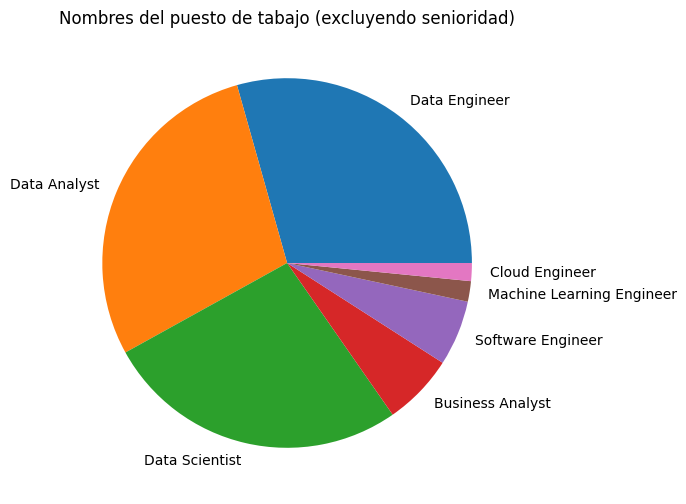

In [ ]:
frecuencia_nombres = jobs['title'].value_counts().reset_index(name='counts')

plt.figure(figsize=(10,6))
plt.title("Nombres del puesto de tabajo (excluyendo senioridad)")

plt.pie(frecuencia_nombres['counts'], labels=frecuencia_nombres['title'])
plt.yticks(fontsize=8)

En esta gráfica se puede comprobar que las suposiciones de los anteriores análisis estaban en lo cierto ya que los puestos ofertados más comunes están relacionados con análisis y ciencia de datos. De nuevo, la causa de este hecho puede ser la importancia que se le dió a la inteligencia artificial durante el año 2023.

### País de las ofertas de trabajo

Text(0, 0.5, 'Número de ofertas')

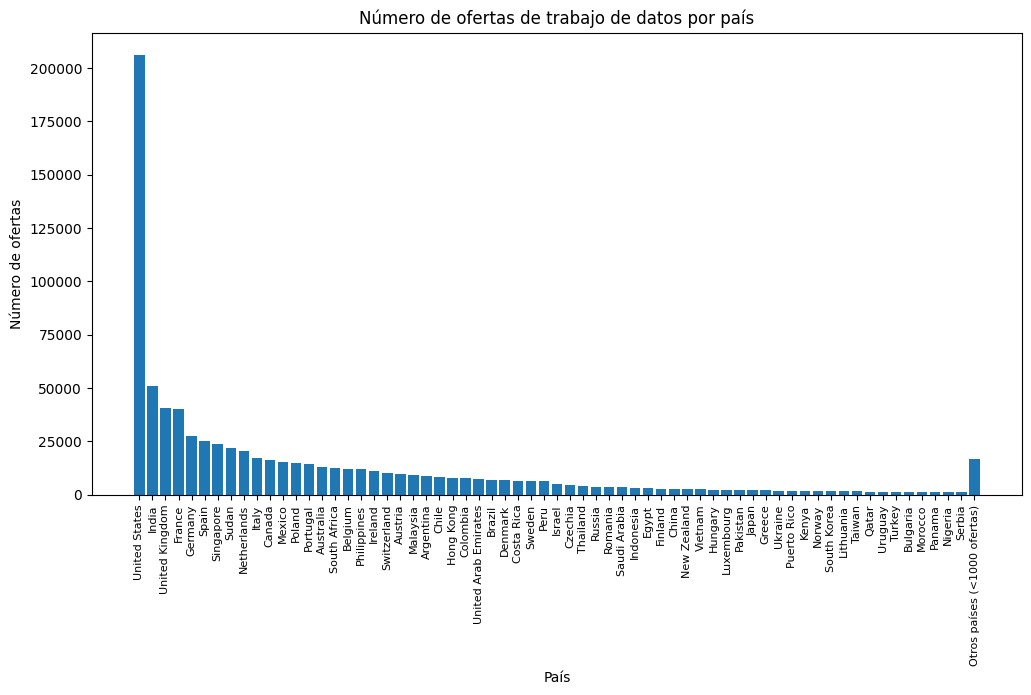

In [ ]:
# obtener frecuencias de países
frecuencia_paises = jobs['job_country'].value_counts().reset_index(name='counts')

# agrupar países con pocas ofertas (<1000)
frecuencia_paises.loc[frecuencia_paises['counts'] < 1000, 'job_country'] = 'Otros países (<1000 ofertas)'
frecuencia_paises = frecuencia_paises.groupby('job_country')['counts'].sum().reset_index()
frecuencia_paises['otros'] = frecuencia_paises['job_country'] != 'Otros países (<1000 ofertas)'
frecuencia_paises = frecuencia_paises.sort_values(['otros', 'counts'], ascending=False)

# dibujar el gráfico
plt.figure(figsize=(12,6))
plt.title("Número de ofertas de trabajo de datos por país")
plt.bar(frecuencia_paises['job_country'],frecuencia_paises['counts'])
plt.xticks(fontsize=8, rotation=90)
plt.xlabel("País")
plt.ylabel("Número de ofertas")

En esta gráfica se puede observar que el país que más empleos genera en el sector del estudio y manejo de datos es estados unidos. Se asume que estos datos indican el país que genera el empleo, no el país en el que se desarrolla el trabajo. También se puede ver que los datos pueden estar bastante sesgados debido a la cantidad de muestras que proceden de un mismo país.

### Número de ofetas de trabajo por fuente



Text(0, 0.5, 'Número de ofertas')

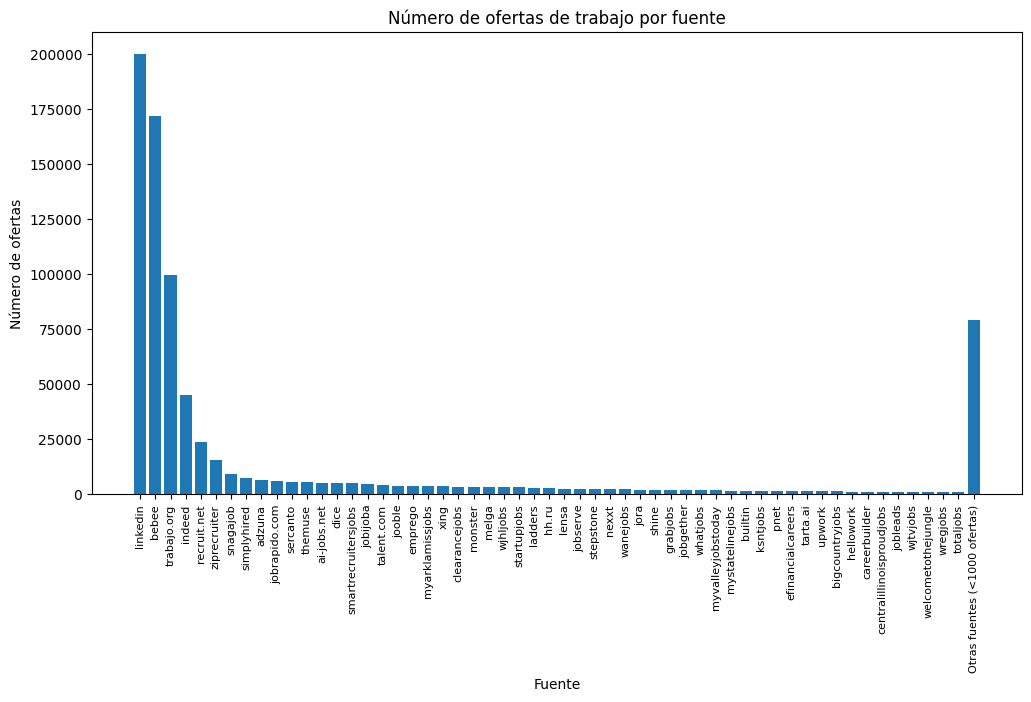

In [ ]:
# obtener frecuencias de países
frecuencia_via = jobs['via'].value_counts().reset_index(name='counts')

# agrupar métodos con pocas ofertas (<1000)
frecuencia_via.loc[frecuencia_via['counts'] < 1000, 'via'] = 'Otras fuentes (<1000 ofertas)'
frecuencia_via = frecuencia_via.groupby('via')['counts'].sum().reset_index()
frecuencia_via['otros'] = frecuencia_via['via'] != 'Otras fuentes (<1000 ofertas)'
frecuencia_via = frecuencia_via.sort_values(['otros', 'counts'], ascending=False)

# dibujar el gráfico
plt.figure(figsize=(12,6))
plt.title("Número de ofertas de trabajo por fuente")
plt.bar(frecuencia_via['via'],frecuencia_via['counts'])
plt.xticks(fontsize=8, rotation=90)
plt.xlabel("Fuente")
plt.ylabel("Número de ofertas")

En este gráfico se puede comprobar que la fuente de ofertas de empleo más recurrente es la red social que fue concebida para este propósito, no obstante, hay algunas otras alternativas. Lo más importante que se puede ver en este gráfico es que hay muchas ofertas de trabajo que se anuncian por vías que, apartentemente no ofertan muchos trabajos, de esta forma podrían haber una gran cantidad de ofertas que no lleguen a publicitarse lo suficiente al no empelar fuentes más conocidas y utilizadas.

## Predicción del nombre del puesto a partir de las habilidades necesarias

Intentaremos predecir el valor de la columna **title** a partir de la información de la columna **skills**. Utilizaremos los dataframes X e Y calculados anteriormente.


Val: 0
Accuracy: 0.9499856162413184
Depth: 57
Leaves: 39707


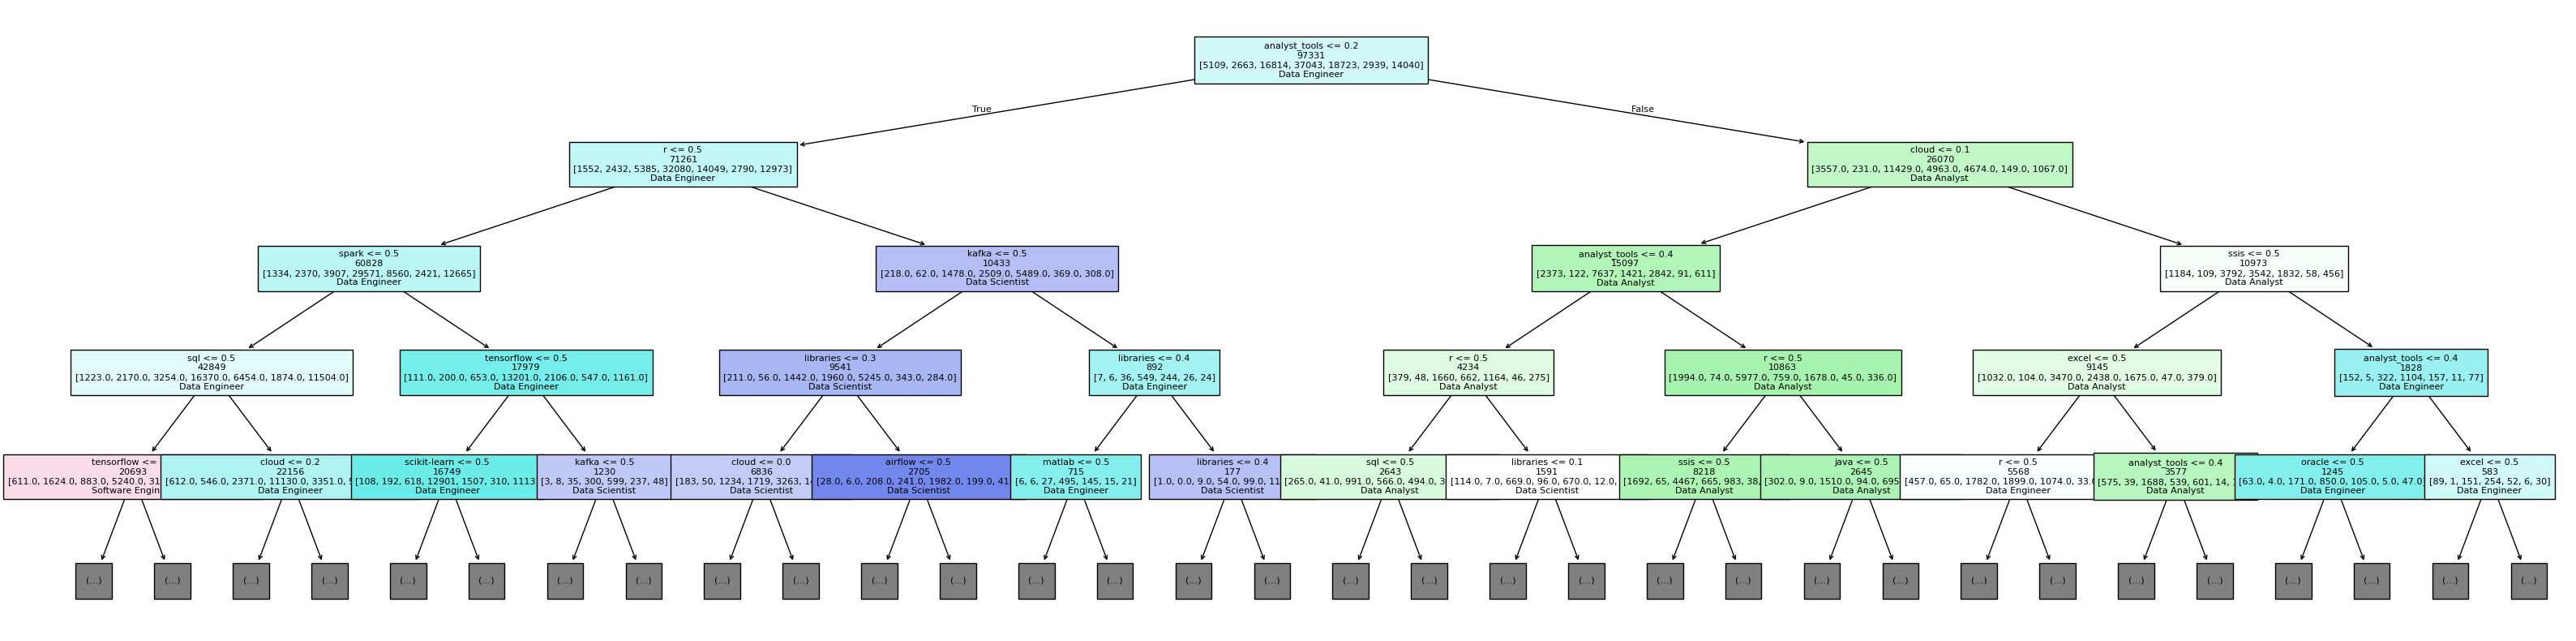

In [ ]:
# train y test
X_train, X_test, y_train, y_test = train_test_split(X, y)

# generar el árbol
test_values = [0] #, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005]
for val in test_values:
    dtree = DecisionTreeClassifier(min_weight_fraction_leaf=val)
    dtree = dtree.fit(X, y)

    # calcular
    pred = dtree.predict(X_test)
    print()
    print(f'Val: {val}')
    print(f'Accuracy: {metrics.accuracy_score(y_test, pred)}')
    print(f'Depth: {dtree.get_depth()}')
    print(f'Leaves: {dtree.get_n_leaves()}')

# mostrar decision tree
plt.figure(figsize=(40, 10))
plot_tree(dtree,
    feature_names=labels_prediccion,
    class_names=leY.classes_,
    impurity=False,
    label = 'none',
    filled=True,
    precision=1,
    max_depth=4,
    fontsize=8
)
plt.show()

Después de tratar de generar árboles de decisión con algo de margen de error, a la mínima que se permitía más de una clase por cada nodo hoja la precisión caía en picado. Esto puede significar que no es posible esta tarea de clasificación con los datos disponibles o simplemente que no hay una conexión real entre el título del empleo y las habilidades que se requieren para el mismo.

## Conclusiones

A partir de los análisis realizados en las secciones anteriores, se pueden obtener diversas conclusiones.

En primer lugar, la industria aumentó su interés en la explotación de la información en 2023 ya que hubo un gran número de ofertas de trabajo relacionadas con el procesamiento y análisis de datos.

En segundo lugar, los trabajos relacionados con el manejo de información se llevan a cabo utilizando principalmente SQL y Python. La primera se debe al formato de almacenamiento de los datos, esto da a entender que estos se almacenan de forma estructurada y probablemente homogénea. La segunda se debe a la versatilidad del lenguaje y su gran soporte, permitiendo ofrecer una interfaz sencilla y fácil de usar a funcionalidades avanzadas que pueden estar implementadas eficientemente.

Otra conclusión que se puede extraer del análisis es que la forma más habitual de anunciar ofertas de trabajo es concentrar dichas ofertas en un canal conocido y bastante usado, como es en este caso LinkedIn. Además, la mayor masa de ofertas se concentra en Estados Unidos, lo cuál abre nuevas cuestiones que no se pueden analizar con los datos disponibles.

Finalmente, los datos recogidos en este conjunto no muestran una relación directa entre las habilidades requeridas y el nombre del puesto de trabajo. Esto se debe a la heterogeneidad de los datos en cuanto a las habilidades requeridas para cada puesto de trabajo y/o a que varios puestos de trabajo solicitan las mismas habilidades.

## Líneas futuras

A partir de las conclusiones y de los propios análisis se pueden ver ciertas faltas en los datos.

En primer lugar, se propone la recolección de datos similares para otros años para poder observar la tendencia de estas ofertas en otros periodos.

Otra posible expansión del trabajo sería recolectar datos similares de otros sectores para analizar el crecimiento de este sector respecto a otros sectores.

Además de las ampliaciones comentadas, tal como se sugiere en las conclusiones, la mayoría de ofertas son de Estados Unidos, pero no se indica si el aspirante deberá trabajar desde dentro de Estados Unidos o si la oferta procede de una empresa sede en Estados Unidos pero permite trabajar en una sede en otro país. Un análisis superficial con la información de frecuencias que proporciona huggingface sugiere que la mayoría de ofertas obligan presencialidad durante las horas de trabajo (no permite teletrabajo), pero este dato individualmente no es suficiente para sacar conclusiones reales.